In [17]:
%%html
<style>
div.input {
    display:none;
}
</style>
... *(clear this cell to run it again)* ...

# Analysis of S-layers crystallization kinetics monitored with tr-SAXS

Jonathan Hermann, Frédéric Poitevin, ...

## Introduction

We consider here time-series collected after addition of Calcium on RsaA monomers, thus following the subsequent crystallization process. 

We aim at extracting the underlying components of the SAXS profiles, and their evolution with time.




### Data

We start by considering the dataset with higher concentration (33.7mg/ml). We edited out the first time-points.

In [2]:
# Useful libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from numpy import genfromtxt
from sklearn.decomposition import FastICA, PCA

In [3]:
# Data loading
filename='../data/33_q.csv'
raw_q = genfromtxt(filename,delimiter=',')
filename='../data/33_t.csv'
raw_t = genfromtxt(filename,delimiter=',')
filename='../data/33_array.csv'
raw_data = genfromtxt(filename, delimiter=',')
print("Raw data size (q,t,I(q,t)) = ",raw_q.shape,raw_t.shape,raw_data.shape)
# we prepare the variables if we need to alter the raw variables
# and we alter it a qmax tmax
qlen = len(raw_q)
qmin = int(qlen*(1/10)) # int(qlen*(1/100))# int(qlen*(5/100)) # 0
qmax = int(qlen*(0.45)) # int(qlen*(1/2)) # int(qlen*(3/4)) # int(qlen*(1/2))
tlen = len(raw_t)
tmin = 0 # int(tlen*(0.33))
tmax = int(tlen*(1)) # int(tlen*(1))
q = raw_q[qmin:qmax]
t = raw_t[tmin:tmax]
data = np.log(raw_data[qmin:qmax,tmin:tmax])
print("New data size (q,t,I(q,t)) = ",q.shape,t.shape,data.shape)

Raw data size (q,t,I(q,t)) =  (791,) (153,) (791, 153)
New data size (q,t,I(q,t)) =  (276,) (153,) (276, 153)


/Users/fpoitevi/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


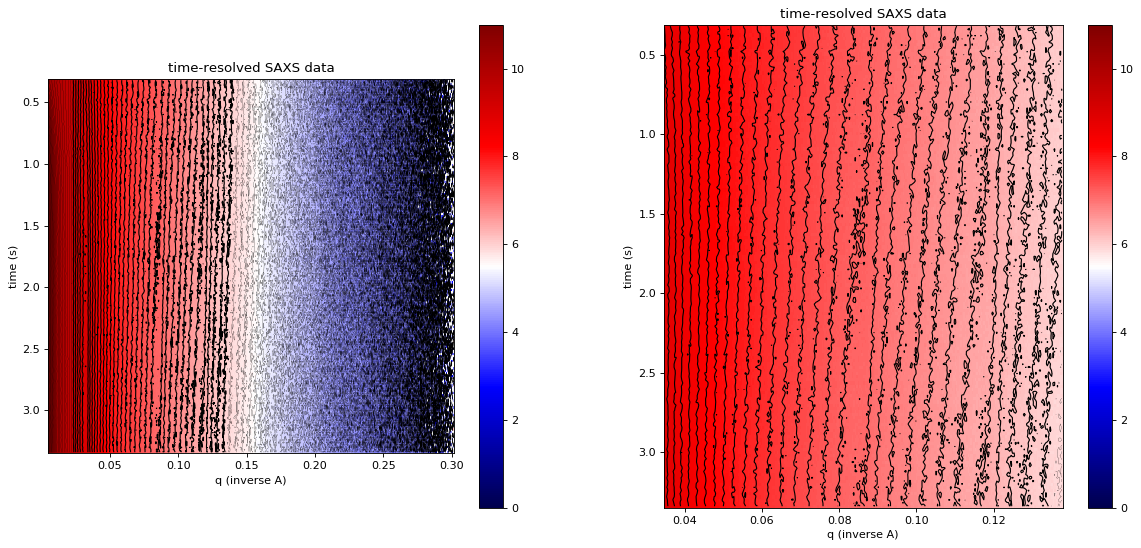

In [623]:
levels1 = np.arange(0,6.5,0.1)
levels2 = np.arange(6,9.5,0.1)
levels3 = np.arange(9.5,15,0.1)
raw_extent=[np.min(raw_q),np.max(raw_q),np.max(raw_t),np.min(raw_t)]
extent=[np.min(q),np.max(q),np.max(t),np.min(t)]
origin='upper'
raw_aspect=max(raw_q)/max(raw_t)
aspect=max(q)/max(t)
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(121)
plt.title('time-resolved SAXS data')
plt.xlabel('q (inverse A)')
plt.ylabel('time (s)')
plt.imshow(np.log(raw_data.T), cmap='seismic',vmin=0,vmax=11,origin=origin,extent=raw_extent,aspect=raw_aspect)
plt.colorbar()
plt.contour(np.log(raw_data.T), levels1, linewidths=0.2,colors='k', origin=origin,extent=raw_extent)
plt.contour(np.log(raw_data.T), levels2, linewidths=1,colors='k', origin=origin,extent=raw_extent)
plt.contour(np.log(raw_data.T), levels3, linewidths=0.2,colors='k', origin=origin,extent=raw_extent)
#
plt.subplot(122)
plt.title('time-resolved SAXS data')
plt.xlabel('q (inverse A)')
plt.ylabel('time (s)')
plt.imshow(data.T, cmap='seismic',vmin=0,vmax=11,origin=origin,extent=extent,aspect=aspect)
plt.colorbar()
plt.contour(data.T, levels1, linewidths=0.2,colors='k', origin=origin,extent=extent)
plt.contour(data.T, levels2, linewidths=1,colors='k', origin=origin,extent=extent)
plt.contour(data.T, levels3, linewidths=0.2,colors='k', origin=origin,extent=extent)
#
plt.show()

The data is shown above on a log scale contoured in steps of 1/10, with an emphasis on the area that see Bragg peaks appearing with time.

### Extraction of underlying components

#### 1. PCA
We start by performing the PCA of the data, noting $I$ the sampled intensity function, $C$ its covariance whose eigenvectors $U_{k}(q)$ are associated with the eigenvalues $\sigma^{2}_{k}$ stored in matrix $D$. The singular value decomposition of $I$ explicitely gives its expansion on the basis of the principal components:
$$C(q,q') \propto \sum_{t}I(q,t)I(q',t) = UDU^{T}$$
$$I(q,t) = \sum_{k}\sigma_{k}v_{k}(t)U_{k}(q) = U\Sigma V^{T}$$

In [624]:
# Compute PCA
pca = PCA(n_components=20)
H = pca.fit_transform(data.T)  # Reconstruct signals based on orthogonal components

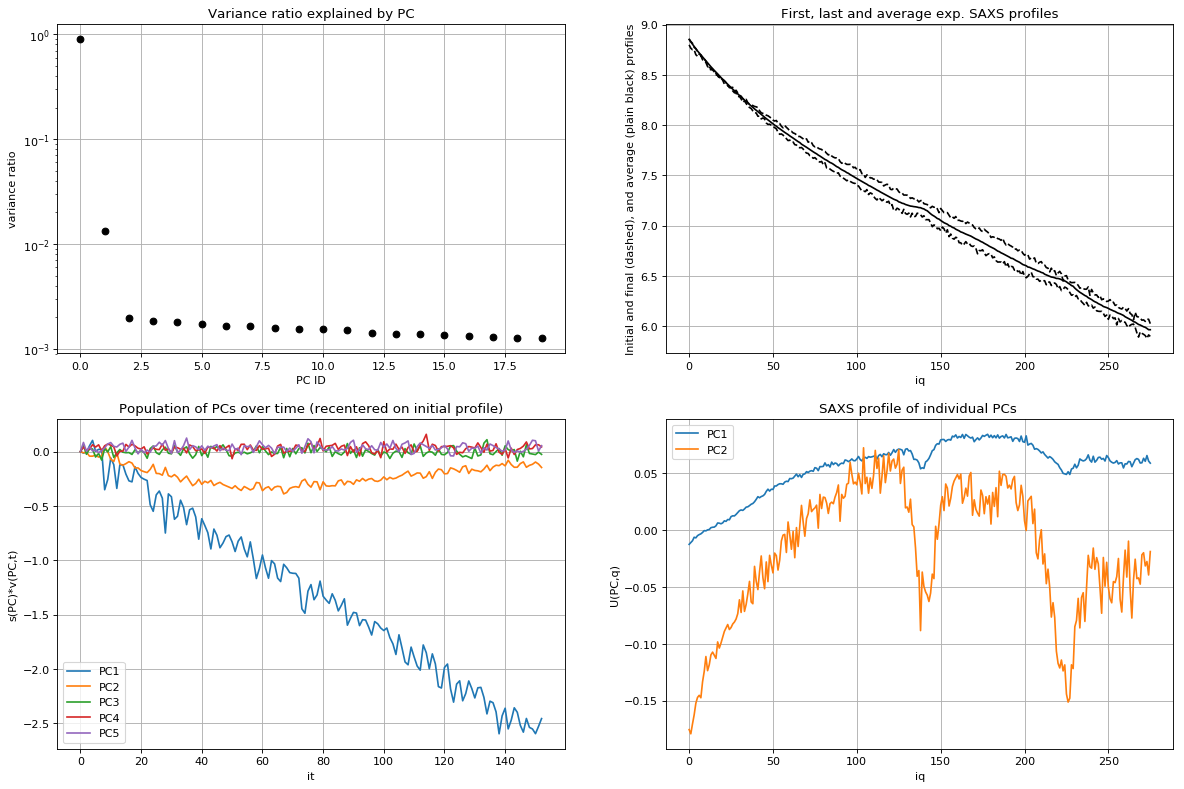

In [625]:
# parameters for figure below
nPCs = 5
eigenval = pca.singular_values_[0:nPCs]
eigenvec = pca.components_.T[:,0:nPCs]
weights  = pca.transform(data.T)
meanvec  = pca.mean_
initvec  = data.T[0,:]
endvec   = data.T[len(t)-1,:]
labels = ['PC1', 'PC2', 'PC3','PC4','PC5']
#
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(221)
plt.grid()
plt.title('Variance ratio explained by PC')
plt.xlabel('PC ID')
plt.ylabel('variance ratio')
plt.semilogy(pca.explained_variance_ratio_, 'ko')
#plt.semilogy(np.cumsum(pca.explained_variance_ratio_), 'ko')
#
plt.subplot(222)
plt.grid()
plt.title('First, last and average exp. SAXS profiles')
plt.xlabel('iq')
plt.ylabel('Initial and final (dashed), and average (plain black) profiles')
plt.plot(initvec, 'k--')
plt.plot(endvec, 'k--')
plt.plot(meanvec, color='black')
#
plt.subplot(223)
plt.grid()
plt.title('Population of PCs over time (recentered on initial profile)')
plt.xlabel('it')
plt.ylabel('s(PC)*v(PC,t)')
for i in np.arange(0,nPCs,1):
    wzero = weights[0,i]
    plt.plot(weights[:,i]-wzero, label=labels[i])
plt.legend()
#
plt.subplot(224)
plt.grid()
plt.title('SAXS profile of individual PCs ')
plt.xlabel('iq')
plt.ylabel('U(PC,q)')
for i in np.arange(0,2,1):
    plt.plot(eigenvec[:,i] , label=labels[i])
plt.legend()
#
plt.show()

It appears that the first PC explains most of the data, and that most of the remaining information is explained by the second component. From their population profile, any component after the third one included is mostly noise. We will use this to denoise the data, by projecting it on the two first components, and proceed to find the individual components below.

#### 2. Denoising

This just amounts to keeping the first $L$ (two here) components, so that:
$$C(q,q') \approx C_{L}(q,q') \propto U_{L}D_{L}U_{L}^{T}$$
$$I(q,t) \approx I_{denoised}(q,t) = \sum_{k}^{L}\sigma_{k}v_{k}(t)U_{k}(q) = U_{L}\Sigma_{L} V_{L}^{T}$$

In [626]:
# Compute PCA (only 2 components)
#pca = PCA(n_components=len(t))
pca = PCA(n_components=2)
H = pca.fit_transform(data.T)
V = pca.transform(data.T)
U = pca.components_
denoised = (pca.mean_ + np.dot(U.T,V.T).T).T

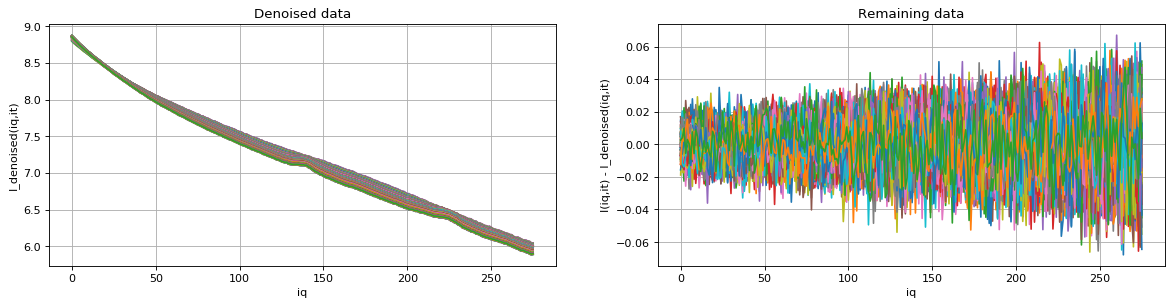

In [627]:
plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(121)
plt.grid()
plt.title('Denoised data')
plt.xlabel('iq')
plt.ylabel('I_denoised(iq,it)')
plt.plot(denoised)
#
plt.subplot(122)
plt.grid()
plt.title('Remaining data')
plt.xlabel('iq')
plt.ylabel('I(iq,it) - I_denoised(iq,it)')
plt.plot(data-denoised)
#
plt.show()

#### 3. fastICA

Here we look for independent components $S(q)$ in the data, by considering the following mixture
$$I_{denoised}(q,t) = \sum_{k}A_{k}(t)S_{k}(q)$$

In [653]:
# Compute ICA
denoised = data
nICs = 2
ica = FastICA(n_components=nICs,algorithm='parallel',fun="logcosh")
S_ = ica.fit_transform(denoised)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

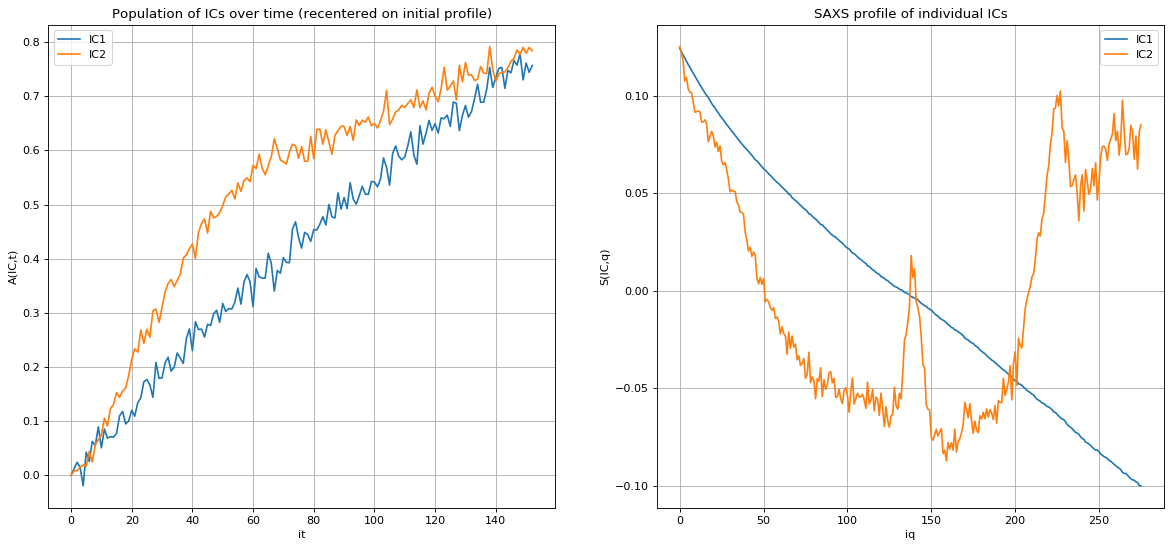

In [654]:
# parameters for figure below
#
labels = ['IC1', 'IC2', 'IC3','IC4', 'IC5', 'IC6','IC7', 'IC8', 'IC9', 'IC10']
#
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(121)
plt.grid()
plt.title('Population of ICs over time (recentered on initial profile)')
plt.xlabel('it')
plt.ylabel('A(IC,t)')
for y_arr, label in zip(A_.T, labels):
    yzero = y_arr[0]
    plt.plot(y_arr - yzero, label=label)
plt.legend()
#
plt.subplot(122)
plt.grid()
plt.title('SAXS profile of individual ICs')
plt.xlabel('iq')
plt.ylabel('S(IC,q)')
for y_arr, label in zip(S_.T, labels):
    plt.plot(y_arr , label=label)
plt.legend()
#
plt.show()

### looking again
below we focus on the low-Q region that was left aside above:

New data size (q,t,I(q,t)) =  (94,) (153,) (94, 153)


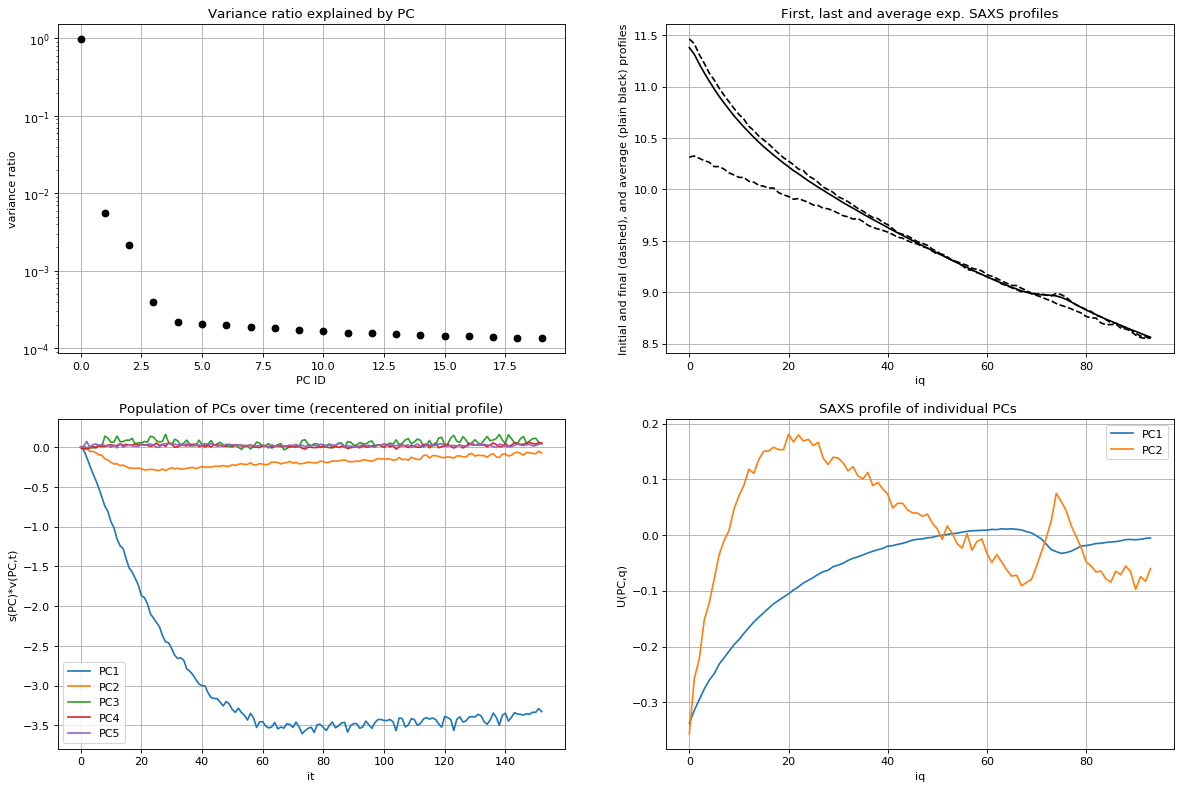

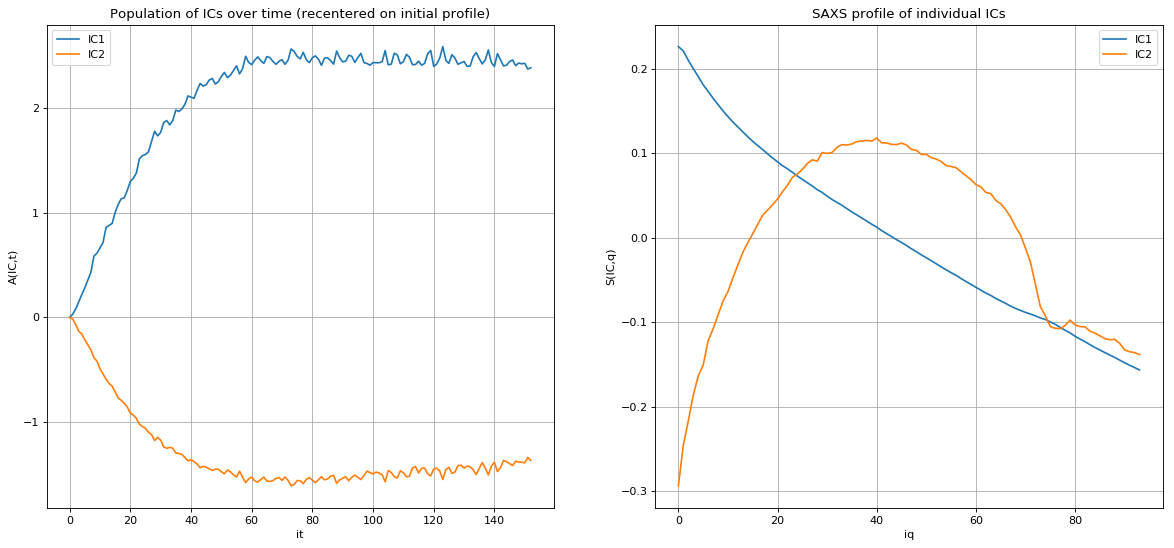

In [16]:
qlen = len(raw_q)
qmin = 0 #int(qlen*(1/10)) # int(qlen*(1/100))# int(qlen*(5/100)) # 0
qmax = int(qlen*(12/100))# int(qlen*(0.45)) # int(qlen*(1/2)) # int(qlen*(3/4)) # int(qlen*(1/2))
tlen = len(raw_t)
tmin = 0 # int(tlen*(0.33))
tmax = int(tlen*(1)) # int(tlen*(1))
q = raw_q[qmin:qmax]
t = raw_t[tmin:tmax]
data = np.log(raw_data[qmin:qmax,tmin:tmax])
print("New data size (q,t,I(q,t)) = ",q.shape,t.shape,data.shape)
#
# Compute PCA
pca = PCA(n_components=20)
H = pca.fit_transform(data.T)  # Reconstruct signals based on orthogonal components

## parameters for figure below
nPCs = 5
eigenval = pca.singular_values_[0:nPCs]
eigenvec = pca.components_.T[:,0:nPCs]
weights  = pca.transform(data.T)
meanvec  = pca.mean_
initvec  = data.T[0,:]
endvec   = data.T[len(t)-1,:]
labels = ['PC1', 'PC2', 'PC3','PC4','PC5']
#
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(221)
plt.grid()
plt.title('Variance ratio explained by PC')
plt.xlabel('PC ID')
plt.ylabel('variance ratio')
plt.semilogy(pca.explained_variance_ratio_, 'ko')
#plt.semilogy(np.cumsum(pca.explained_variance_ratio_), 'ko')
#
plt.subplot(222)
plt.grid()
plt.title('First, last and average exp. SAXS profiles')
plt.xlabel('iq')
plt.ylabel('Initial and final (dashed), and average (plain black) profiles')
plt.plot(initvec, 'k--')
plt.plot(endvec, 'k--')
plt.plot(meanvec, color='black')
#
plt.subplot(223)
plt.grid()
plt.title('Population of PCs over time (recentered on initial profile)')
plt.xlabel('it')
plt.ylabel('s(PC)*v(PC,t)')
for i in np.arange(0,nPCs,1):
    wzero = weights[0,i]
    plt.plot(weights[:,i]-wzero, label=labels[i])
plt.legend()
#
plt.subplot(224)
plt.grid()
plt.title('SAXS profile of individual PCs ')
plt.xlabel('iq')
plt.ylabel('U(PC,q)')
for i in np.arange(0,2,1):
    plt.plot(eigenvec[:,i] , label=labels[i])
plt.legend()
#
plt.show()
#
denoised = data
nICs = 2
ica = FastICA(n_components=nICs,algorithm='parallel',fun="logcosh")
S_ = ica.fit_transform(denoised)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
#
# parameters for figure below
#
labels = ['IC1', 'IC2', 'IC3','IC4', 'IC5', 'IC6','IC7', 'IC8', 'IC9', 'IC10']
#
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
#
plt.subplot(121)
plt.grid()
plt.title('Population of ICs over time (recentered on initial profile)')
plt.xlabel('it')
plt.ylabel('A(IC,t)')
for y_arr, label in zip(A_.T, labels):
    yzero = y_arr[0]
    plt.plot(y_arr - yzero, label=label)
plt.legend()
#
plt.subplot(122)
plt.grid()
plt.title('SAXS profile of individual ICs')
plt.xlabel('iq')
plt.ylabel('S(IC,q)')
for y_arr, label in zip(S_.T, labels):
    plt.plot(y_arr , label=label)
plt.legend()
#
plt.show()